# Dynamic Time Warping

Based on:
http://nipunbatra.github.io/2014/07/dtw/


In [1]:
import numpy
import matplotlib.pyplot as plt
import matplotlib 
%matplotlib inline
import ctypes

In [2]:
%%file dtw_python.c

#include <stdlib.h>
#include <stdio.h>
#include <math.h>
#include <string.h> // only for the memcpy
#include <errno.h>

/*
    Note: 
    Using ctypes, numpy arrays always look like a vector in C, not a matrix (even if the numpy array IS a matrix)
    The reason is that numpy matrices are always arrays also inside numpy :)    
*/

float path_cost(int len_x, int len_y, float *accumulated_cost, float *distances);
void generates_accumulated_cost(int len_x, int len_y, float *accumulated_cost, float *distances);
void generates_distances(int len_x, int len_y, int dim, float *distances, float *x, float *y);
void returns_path(int *output, int size);

int *path = NULL;
int path_counter = 0;


int returns_path_length(){
    return path_counter;
}

void returns_path(int *output, int size){
    memcpy(output,path,2*sizeof(int)*size);
    free(path);
    path = NULL;
}

float path_cost(int len_x, int len_y, float *accumulated_cost, float *distances)
{
    int i = len_x-1;
    int j = len_y-1;
    int n_malloc_i = 1;
    float min_value = 0;
    float cost = 0;

    path_counter = 0;
    
    if (path == NULL)
    {
        path = malloc(100*2*sizeof(int));
        if (path==NULL)
            return EXIT_FAILURE;
    }
    else
    {
        free(path);
        path = NULL;
        path = malloc(100*2*sizeof(int));
        if (path==NULL)
            return EXIT_FAILURE;        
    }
    
    *path = i;
    *(path+1) = j;
    path_counter++;
    
    while((i>0)||(j>0))
    {        
        if(i==0)
            j = j - 1;
        else if(j==0)
            i = i - 1;
        else
        {
            // Calculates the min value
            if (*(accumulated_cost+((i-1)*len_y)+(j-1))>*(accumulated_cost+((i-1)*len_y)+j))
                min_value = *(accumulated_cost+len_y*(i-1)+j);
            else if (*(accumulated_cost+((i-1)*len_y)+(j-1))>*(accumulated_cost+(i*len_y)+(j-1)))
                min_value = *(accumulated_cost+(i*len_y)+(j-1));
            else
                min_value = *(accumulated_cost+((i-1)*len_y)+(j-1));

            // Calculates the next step based on the min value
            if (*(accumulated_cost+len_y*(i-1)+j) == min_value)
                i = i - 1;
            else if (*(accumulated_cost+len_y*i+(j-1)) == min_value)
                j = j - 1;
            else
            {
                i = i - 1;
                j = j - 1;
            }
        }
                         
        if (((float)path_counter/n_malloc_i)<2*100)
        {
            *(path+path_counter*2)=i;
            *(path+path_counter*2+1)=j;
            path_counter++;
        }
        else
        {
            n_malloc_i++;
            path = realloc(path,n_malloc_i*100*2*sizeof(int));
            
            if (path==NULL)
                return EXIT_FAILURE;            
            
            *(path+path_counter*2)=i;
            *(path+path_counter*2+1)=j;
            path_counter++;
        }
    }
    for (int i=0; i<path_counter; i++)
    {
        const int x = *(path+i*2);
        const int y = *(path+i*2+1);        
        cost = cost + *(distances+len_y*x+y);
    }
                         
    return cost;
}


void generates_accumulated_cost(int len_x, int len_y, float *accumulated_cost, float *distances)
{
    float min_value = 0;
    
    *(accumulated_cost)= *(distances);
    
    for (int i=1; i<len_y; i++)
        *(accumulated_cost+i) = *(distances+i) + *(accumulated_cost+i-1);
    
    for (int j=1; j<len_x; j++)
        *(accumulated_cost+(j*len_y)) = *(distances+(j*len_y)) + *(accumulated_cost+((j-1)*len_y));    

    for (int i=1; i<len_x; i++)
    {
        for (int j=1; j<len_y; j++)
        {
            // Calculates the min value
            if (*(accumulated_cost+((i-1)*len_y)+(j-1))>*(accumulated_cost+((i-1)*len_y)+j))
                min_value = *(accumulated_cost+len_y*(i-1)+j);
            else if (*(accumulated_cost+((i-1)*len_y)+(j-1))>*(accumulated_cost+(i*len_y)+(j-1)))
                min_value = *(accumulated_cost+(i*len_y)+(j-1));
            else
                min_value = *(accumulated_cost+((i-1)*len_y)+(j-1));

            *(accumulated_cost+(i*len_y)+j)= min_value + *(distances+(i*len_y)+j);
        }
        
    }
}

void generates_distances(int len_x, int len_y, int dim, float *distances, float *x, float *y)
{
    for (int i=0; i<len_x; i++)
    {
        for (int j=0; j<len_y; j++)
        {
            *(distances+(i*len_y)+j) = 0; //initialises
            
            //printf("i,j: %d %d\n",i,j);
            
            if (dim>1)
                for (int d=0; d<dim; d++)
                {
                    *(distances+(i*len_y)+j) += pow(*(x+(i*dim)+d)-*(y+(j*dim)+d),2);
                }
            else
                *(distances+(i*len_y)+j) += pow(*(x+i)-*(y+j),2);
            
            *(distances+(i*len_y)+j) = sqrt(*(distances+(i*len_y)+j));
            
            //printf("(i*len_y),j: %d %d\n",(i*len_y),j);
        }
    }
}


Overwriting dtw_python.c


In [3]:
# In Linux it's necessary to add these: -lrt -lm
!gcc -shared -Wl,-install_name,dtw_python.so -o dtw_python.so -fPIC dtw_python.c -O3 -std=gnu99 -Wall -ffast-math -mtune=native 

In [4]:
DTW=ctypes.CDLL("./dtw_python.so")

# void generates_distances(int len_x, int len_y, int dim, float *distances, float *x, float *y)
generates_distances = DTW.generates_distances
generates_distances.restype = None
generates_distances.argtypes = [
    ctypes.c_int32,
    ctypes.c_int32,
    ctypes.c_int32,
    numpy.ctypeslib.ndpointer(dtype=numpy.float32, flags='ALIGNED,C_CONTIGUOUS'),
    numpy.ctypeslib.ndpointer(dtype=numpy.float32, flags='ALIGNED,C_CONTIGUOUS'),
    numpy.ctypeslib.ndpointer(dtype=numpy.float32, flags='ALIGNED,C_CONTIGUOUS')]

def distances_matrix(x,y):

    assert len(x.shape)==len(y.shape), "Inputs must have the same number of columns"
    
    if len(x.shape)==1:
        dim = ctypes.c_int32(1)
    else:
        dim = ctypes.c_int32(x.shape[1])
    
    len_x = ctypes.c_int32(x.shape[0])
    len_y = ctypes.c_int32(y.shape[0]) 
    
    distances = numpy.empty((x.shape[0],y.shape[0]),dtype=numpy.float32)
    
    
    generates_distances(len_x, len_y, dim, distances, x.astype(dtype=numpy.float32), y.astype(dtype=numpy.float32))
    
    return distances#.reshape((x.shape[0],y.shape[0]))

# void generates_accumulated_cost(int len_x, int len_y, float *accumulated_cost, float *distances)
generates_accumulated_cost = DTW.generates_accumulated_cost
generates_accumulated_cost.restype = None
generates_accumulated_cost.argtypes = [
    ctypes.c_int32,
    ctypes.c_int32,
    numpy.ctypeslib.ndpointer(dtype=numpy.float32, flags='ALIGNED,C_CONTIGUOUS'),
    numpy.ctypeslib.ndpointer(dtype=numpy.float32, flags='ALIGNED,C_CONTIGUOUS')]

def accumulated_cost_matrix(x,y,distances):
    len_x = ctypes.c_int32(x.shape[0])
    len_y = ctypes.c_int32(y.shape[0]) 
    accumulated_cost = numpy.empty((x.shape[0],y.shape[0]),dtype=numpy.float32)
    
    generates_accumulated_cost(len_x, len_y, accumulated_cost, distances)
    
    return accumulated_cost

# float path_cost(int len_x, int len_y, float *accumulated_cost, float *distances)
path_cost = DTW.path_cost
path_cost.restype = ctypes.c_float
path_cost.argtypes = [
    ctypes.c_int32,
    ctypes.c_int32,
    numpy.ctypeslib.ndpointer(dtype=numpy.float32, flags='ALIGNED,C_CONTIGUOUS'),
    numpy.ctypeslib.ndpointer(dtype=numpy.float32, flags='ALIGNED,C_CONTIGUOUS')]

# int returns_path_length()
returns_path_length = DTW.returns_path_length
returns_path_length.restype = ctypes.c_int32
returns_path_length.argtypes = []

# void returns_path(int *output, int size)
returns_path = DTW.returns_path
returns_path.restype = None
returns_path.argtypes = [
    numpy.ctypeslib.ndpointer(dtype=numpy.int32, flags='ALIGNED,C_CONTIGUOUS'),
    ctypes.c_int32]


def path_cost_calculation(x,y,distances,accumulated_cost):
    len_x = ctypes.c_int32(x.shape[0])
    len_y = ctypes.c_int32(y.shape[0]) 
    
    cost = path_cost(len_x, len_y, accumulated_cost, distances)

    path_length = returns_path_length()
    
    path = numpy.empty((path_length,2),dtype=numpy.int32)
    
    returns_path(path, path_length)
    
    return path,cost

In [5]:
def distance_cost_plot(distances):
    distances=distances.T
    plt.figure(figsize =(10,10))
    im = plt.imshow(distances, interpolation='nearest', cmap='Reds') 
    plt.gca().invert_yaxis()
    plt.ylabel("y")
    plt.xlabel("x")
    plt.xticks(range(distances.shape[1]),range(distances.shape[1]))
    plt.yticks(range(distances.shape[0]),range(distances.shape[0]))
    plt.grid()
    plt.colorbar();

In [6]:
def path_cost_p(x, y, accumulated_cost, distances):
    
    path = [[len(x)-1, len(y)-1]]
    
    cost = 0
    
    i = len(x)-1
    j = len(y)-1
    
    while i>0 or j>0:
        if i==0:
            j = j - 1
        elif j==0:
            i = i - 1
        else:
            if accumulated_cost[i-1, j] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                i = i - 1
            elif accumulated_cost[i, j-1] == min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]):
                j = j - 1
            else:
                i = i - 1
                j = j - 1
        path.append([i, j])
    for [x, y] in path:
        cost = cost +distances[x, y]
    return path, cost

In [7]:
def generates_accumulated_cost_p(x,y,distances):
    accumulated_cost = numpy.zeros((len(x), len(y)))
    
    accumulated_cost[0,0] = distances[0,0]
    
    for i in range(1, len(x)):
        accumulated_cost[i,0] = distances[i, 0] + accumulated_cost[i-1, 0]

    for j in range(1, len(y)):
        accumulated_cost[0,j] = distances[0,j] + accumulated_cost[0, j-1]
        
    for i in range(1, len(x)):
        for j in range(1, len(y)):
            accumulated_cost[i, j] = min(accumulated_cost[i-1, j-1], accumulated_cost[i-1, j], accumulated_cost[i, j-1]) + distances[i, j]
            
    return accumulated_cost

In [8]:
def generates_distances2D(x,y):
    '''
    Generates the distance matrix used with Dynamic Time Warping
    '''
    # Creates the helper matrix
    helper_matrix=numpy.ones((y.shape[0],x.shape[0]))

    # Generates (y.shape[0]) copies of each value in original_drawing
    x_all=(x[:,0]*helper_matrix)
    y_all=(x[:,1]*helper_matrix)

    # returns all the distances between original points and generated ones
    return (numpy.sqrt((x_all.T-y[:,0])**2+(y_all.T-y[:,1])**2))

In [9]:
def generates_distances3D(x,y):
    '''
    Generates the distance matrix used with Dynamic Time Warping
    '''
    # Creates the helper matrix
    helper_matrix=numpy.ones((y.shape[0],x.shape[0]))

    # Generates (y.shape[0]) copies of each value in original_drawing
    x_all=(x[:,0]*helper_matrix)
    y_all=(x[:,1]*helper_matrix)
    z_all=(x[:,2]*helper_matrix)

    # returns all the distances between original points and generated ones
    return (numpy.sqrt((x_all.T-y[:,0])**2+(y_all.T-y[:,1])**2+(z_all.T-y[:,2])**2))

In [10]:
def generates_distances_N(x,y):
    '''
    Generates the distance matrix used with Dynamic Time Warping 
    => for systems with N dimensions
    '''
    assert len(x.shape)==len(y.shape), "Inputs must have the same number of columns"
    
    if len(x.shape)==1:
        x=x.reshape((x.shape[0],1))
        y=y.reshape((y.shape[0],1))
    
    assert x.shape[1]==y.shape[1], "Inputs must have the same number of columns" # verifies if the second dimension matches
    # Creates the helper matrix
    helper_matrix=numpy.ones((y.shape[0],x.shape[0]))

    # returns all the distances between original points and generated ones
    return (numpy.sqrt(numpy.array([((x[:,i]*helper_matrix).T-y[:,i])**2 for i in range(x.shape[1])]).sum(axis=0)))

[[ 0.  0.  0.  0.]
 [ 1.  1.  1.  1.]
 [ 2.  2.  2.  2.]
 [ 3.  3.  3.  3.]
 [ 4.  4.  4.  4.]]


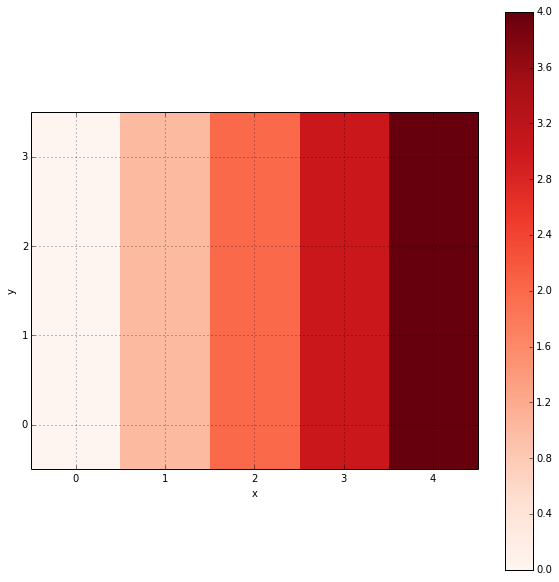

In [11]:
x = numpy.array([0,1,2,3,4])
y = numpy.zeros(4)

dist=generates_distances_N(x,y)
print dist
distance_cost_plot(dist)

[[ 0.  0.  0.  0.]
 [ 1.  1.  1.  1.]
 [ 2.  2.  2.  2.]
 [ 3.  3.  3.  3.]
 [ 4.  4.  4.  4.]]


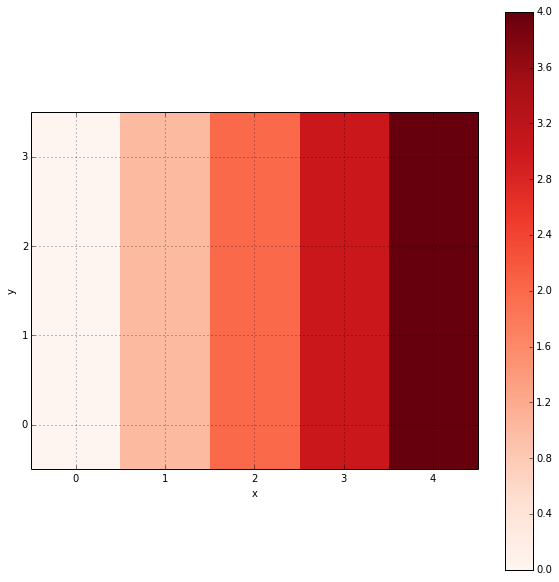

In [12]:
dist=distances_matrix(x,y)
print dist
distance_cost_plot(dist)

[[ 0.  1.  2.  3.]
 [ 0.  1.  2.  3.]
 [ 0.  1.  2.  3.]]


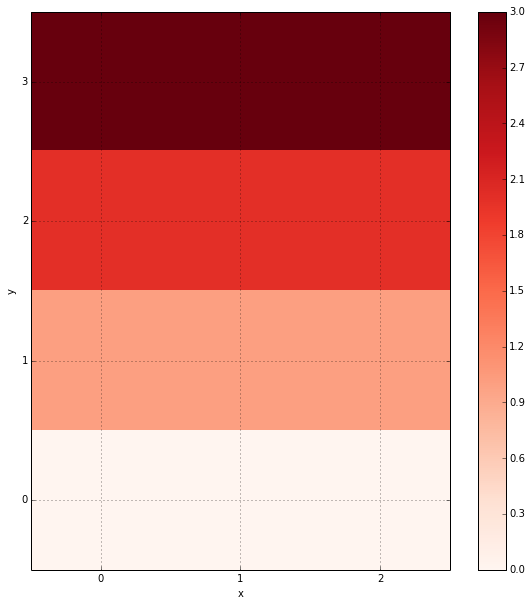

In [13]:
x = numpy.zeros(3)
y = numpy.array([0,1,2,3])

dist=generates_distances_N(x,y)
print dist
distance_cost_plot(dist)

[[ 0.  1.  2.  3.]
 [ 0.  1.  2.  3.]
 [ 0.  1.  2.  3.]]


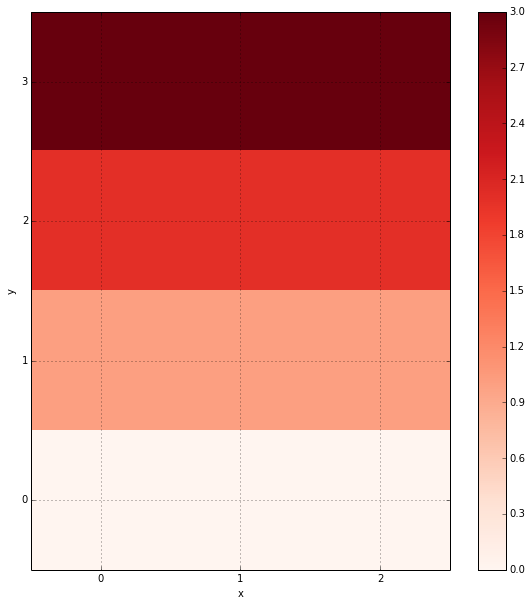

In [14]:
dist=distances_matrix(x,y)
print dist
distance_cost_plot(dist)

[[ 1.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]]


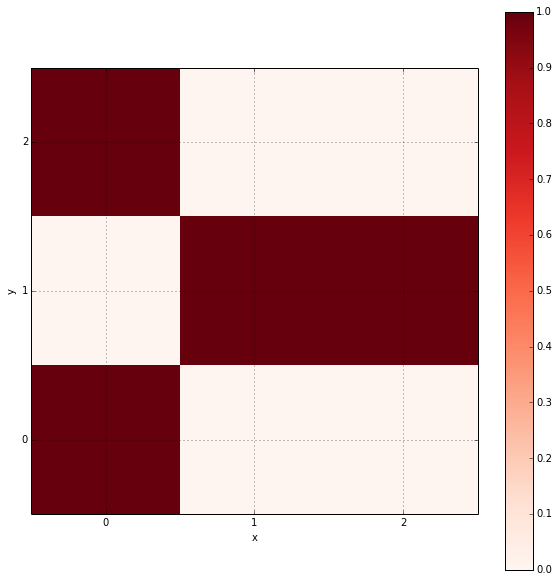

In [15]:
x = numpy.zeros((3,4))
y = numpy.zeros((3,4))

x[0,:]=[1,0,0,0]

y[1,:]=[1,0,0,0]

dist=generates_distances_N(x,y)
print dist
distance_cost_plot(dist)

[[ 1.  0.  1.]
 [ 0.  1.  0.]
 [ 0.  1.  0.]]


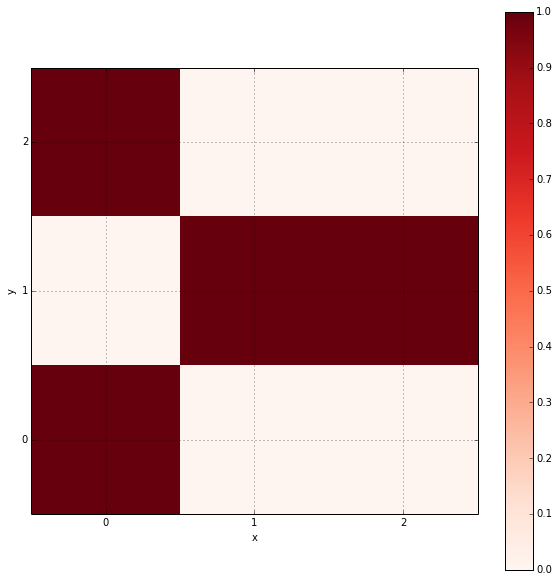

In [16]:
dist=distances_matrix(x,y)
print dist
distance_cost_plot(dist)

[[ 1.          1.41421356  1.        ]
 [ 0.          1.          0.        ]
 [ 0.          1.          0.        ]]


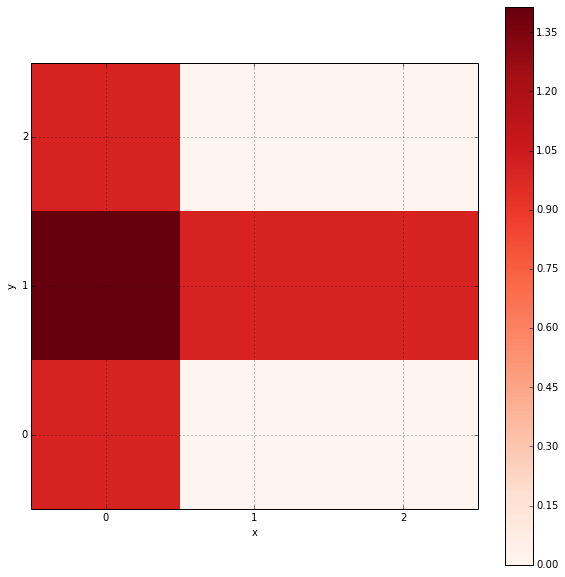

In [17]:
x = numpy.zeros((3,4))
y = numpy.zeros((3,4))

x[0,:]=[0,1,0,0]

y[1,:]=[1,0,0,0]

dist=generates_distances_N(x,y)
print dist
distance_cost_plot(dist)

[[ 1.          1.41421354  1.        ]
 [ 0.          1.          0.        ]
 [ 0.          1.          0.        ]]


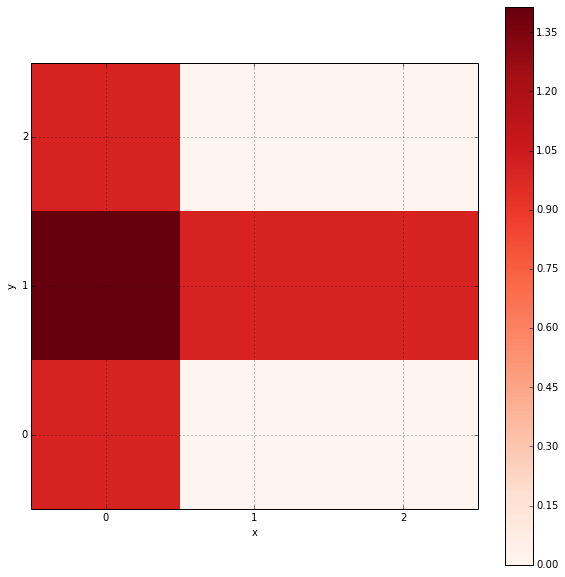

In [18]:
dist=distances_matrix(x,y)
print dist
distance_cost_plot(dist)

In [19]:
x = numpy.random.rand(300,4)
y = numpy.random.rand(500,4)

In [20]:
%%time
dist=generates_distances_N(x,y)

CPU times: user 5.03 ms, sys: 2.37 ms, total: 7.4 ms
Wall time: 6.53 ms


In [22]:
%%time
dist=distances_matrix(x,y)

CPU times: user 1.42 ms, sys: 541 µs, total: 1.96 ms
Wall time: 1.33 ms


In [24]:
x = numpy.random.rand(3000,3)
y = numpy.random.rand(5000,3)

In [25]:
%%time
dist=generates_distances_N(x,y)

CPU times: user 913 ms, sys: 404 ms, total: 1.32 s
Wall time: 1.32 s


In [26]:
%%time
dist=generates_distances3D(x,y)

CPU times: user 403 ms, sys: 286 ms, total: 690 ms
Wall time: 689 ms


In [27]:
%%time
dist=distances_matrix(x,y)

CPU times: user 81.7 ms, sys: 15.8 ms, total: 97.5 ms
Wall time: 97 ms


In [28]:
x = numpy.random.rand(3000,2)
y = numpy.random.rand(5000,2)

In [29]:
%%time
dist=generates_distances_N(x,y)

CPU times: user 646 ms, sys: 242 ms, total: 888 ms
Wall time: 887 ms


In [30]:
%%time
dist=generates_distances2D(x,y)

CPU times: user 260 ms, sys: 151 ms, total: 411 ms
Wall time: 410 ms


In [31]:
%%time
dist=distances_matrix(x,y)

CPU times: user 58.6 ms, sys: 16.7 ms, total: 75.3 ms
Wall time: 74.9 ms


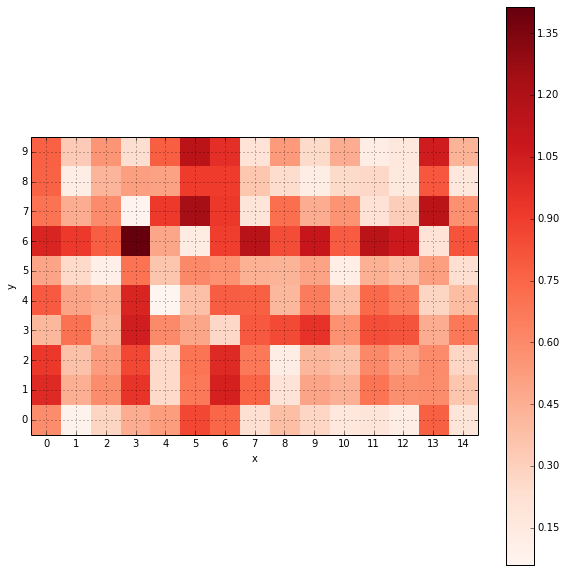

In [54]:
x = numpy.random.rand(15,2)
y = numpy.random.rand(10,2)

x[numpy.random.randint(1,10),:]=[0,1]

y[numpy.random.randint(1,10),:]=[1,0]

dist=generates_distances_N(x,y)
# print dist
distance_cost_plot(dist)

In [63]:
%%time
dist=generates_distances2D(x,y)

CPU times: user 61 µs, sys: 7 µs, total: 68 µs
Wall time: 64.1 µs


In [64]:
%%time
accumulated_cost=generates_accumulated_cost_p(x,y,dist)

CPU times: user 176 µs, sys: 67 µs, total: 243 µs
Wall time: 198 µs


In [65]:
%%time
path,cost = path_cost_p(x, y, accumulated_cost, dist)
path=numpy.array(path)
print cost

6.45074471397
CPU times: user 102 µs, sys: 19 µs, total: 121 µs
Wall time: 111 µs


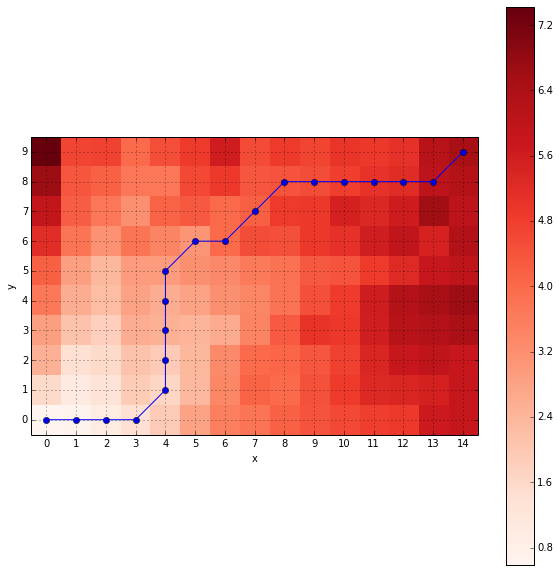

In [66]:
distance_cost_plot(accumulated_cost)
plt.plot(path[:,0],path[:,1],'o-')
plt.show()

In [67]:
%%time
dist=distances_matrix(x,y)

CPU times: user 75 µs, sys: 8 µs, total: 83 µs
Wall time: 78.2 µs


In [68]:
%%time
accumulated_cost=accumulated_cost_matrix(x,y,dist)

CPU times: user 59 µs, sys: 9 µs, total: 68 µs
Wall time: 63.9 µs


In [69]:
%%time
path,cost = path_cost_calculation(x,y,dist,accumulated_cost)
print cost

6.45074462891
CPU times: user 117 µs, sys: 37 µs, total: 154 µs
Wall time: 130 µs


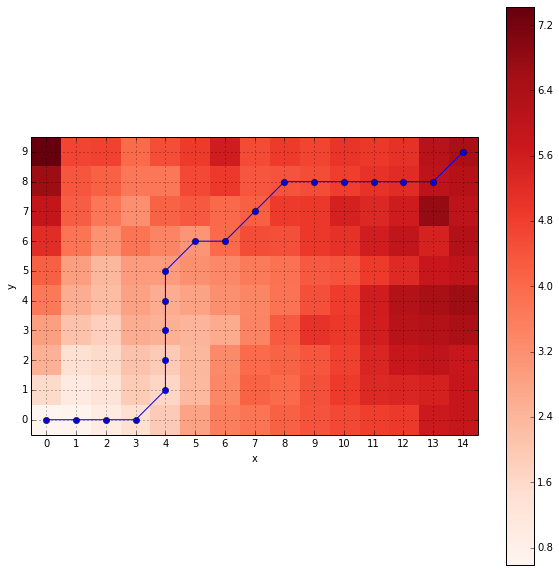

In [70]:
distance_cost_plot(accumulated_cost)
plt.plot(path[:,0],path[:,1],'o-')
plt.show()